# Regression on the deer data

**Goal:** In this notebook you will work with TFP. You will set up different regression models that are able to output different conditional probability distribution. You will define all models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You compare the performace of all regression model on the test dataset.  


**Usage:** This notebook should be a case study that you can do by yourself. Try to solve it the exercises and then look at the solution and compare your results.

**Dataset:** You work with a dataset that describes deer related car accidents in the years 2002 until 2011 on roads in Bavaria, Germany. It counts the number of deers killed during 30-minute periods anywhere in Bavaria. This dataset has been used previously for the analysis of count data in the statistics literature, and is originally from https://zenodo.org/record/17179. 

**Content:**
* Load and split the dataset 
* Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$
* Fit a poisson regression model in keras and TFP
* Fit a poisson regression model with hidden layers in keras and TFP
* Fit a zero-inflated poisson regression model im keras and TFP
* Fit a zero-inflated poisson regression model with hidden layers in keras and TFP
* Fit a mixture model regression model in keras and TFP
* Fit a mixture model regression model with hidden layers in keras and TFP
* Compare the different models based on the NLL loss on the test dataset

***Hint: Use the previous notebooks form this chapter as helf an reference when you try to solve the exercises***  
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_04.ipynb)


In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


#### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_probability as tfp
import os
from urllib.request import urlretrieve
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


### Loading and preprocessing of the data

In the next cells you download the dataset and install the feather-format library, if it is not already installed. The dataset already is splited in a train and test dataset, the trainset contains data from the year 2002 until 2010 and the testset contains data from 2010 until almost 2012. You do a bit of preprocessing by changing the categorical variables "daytime" and "weekday" into a dummy encoding, which is similar to the one hot encoding. You delete the information of the year and normalize the "time" variable to be in the range from 0 to 1. The target variable "wild" stands for the number of deers killed during that 30-minute period.

In [0]:
try:
    import feather
except:
    !pip install feather-format
    import feather

In [0]:
def get_if_not_there(filename = 'deer_train.feather'):
    if not os.path.isfile(filename):
         urlretrieve('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/{}'.format(filename),
                    filename = filename)

get_if_not_there('deer_train.feather')
get_if_not_there('deer_test.feather')

In [0]:
df_train = feather.read_dataframe('deer_train.feather')
df_test = feather.read_dataframe('deer_test.feather')

In [6]:
df_train[0:2]

,wild,year,time,daytime,weekday
0,0,2002.0,0.000000,night.am,Sunday
1,0,2002.0,0.020833,night.am,Sunday


In [7]:
df_test[0:2]

,wild,year,time,daytime,weekday
0,0,2010.0,2922.000000,night.am,Sunday
1,2,2010.0,2922.020833,night.am,Sunday


In [11]:
print(df_train["daytime"].unique())
print(df_train["weekday"].unique())

[night.am, pre.sunrise.am, post.sunrise.am, day.am, day.pm, pre.sunset.pm, post.sunset.pm, night.pm]
Categories (8, object): [night.am, pre.sunrise.am, post.sunrise.am, day.am, day.pm, pre.sunset.pm,
                         post.sunset.pm, night.pm]
[Sunday, Wednesday, Thursday, Friday, Saturday, Monday, Tuesday]
Categories (7, object): [Sunday, Wednesday, Thursday, Friday, Saturday, Monday, Tuesday]


In [0]:
y_train = df_train.iloc[:,0].to_numpy(dtype='float32')
y_test = df_test.iloc[:,0].to_numpy(dtype='float32')
X_train = pd.get_dummies(df_train.iloc[:,2:]) #We wont use the year
X_test = pd.get_dummies(df_test.iloc[:,2:])
X_train.iloc[:,0] = X_train.iloc[:,0]/2922.02    #We divide by the maximal number to be in the range 0 to 1
X_test.iloc[:,0] = X_test.iloc[:,0]/2922.02 
del df_train, df_test

In the next two cells you see how the two datasets look like after the preprocessing. You have around 140'000 observations in the train dataset and around 35'000 in the test dataset.

In [13]:
X_train[0:2]

,time,daytime_day.am,daytime_night.am,daytime_pre.sunrise.am,daytime_post.sunrise.am,daytime_day.pm,daytime_night.pm,daytime_pre.sunset.pm,daytime_post.sunset.pm,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weekday_Sunday
0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.000007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
X_test[0:2]

,time,daytime_day.am,daytime_night.am,daytime_pre.sunrise.am,daytime_post.sunrise.am,daytime_day.pm,daytime_night.pm,daytime_pre.sunset.pm,daytime_post.sunset.pm,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weekday_Sunday
0,0.999993,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
X_train = X_train.to_numpy(dtype='float32')
X_test = X_test.to_numpy(dtype='float32')

X_train.shape,X_test.shape

((140256, 16), (35040, 16))

Let's look at the distribution of the traget variable: the number of deers killed during that 30-minute period. As you can see the distribution is very skewed, for most of the observation the nummber of deers killed by a car is, as you would expect, zero. On the other hand you can see taht there were twp 30-minute periods where 37 and 38 deers died! 

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 37. 38.]
[58184 31788 16339  9556  6367  4558  3274  2363  1766  1352  1079   870
   635   490   408   290   235   188   122   113    70    57    35    34
    23    23    11     7     6     4     3     3     1     1     1]


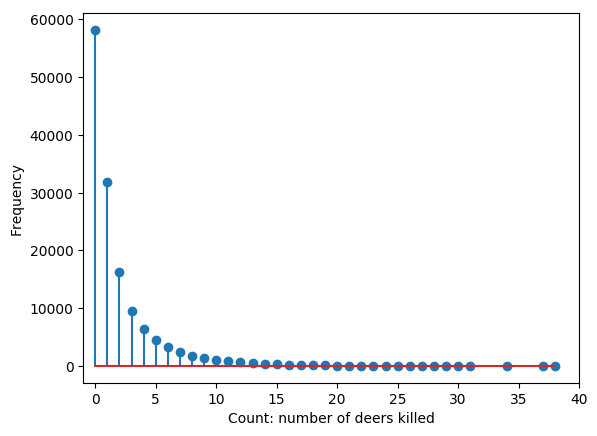

In [20]:
print(np.unique(y_train, return_counts=True)[0])
print(np.unique(y_train, return_counts=True)[1])
vals, counts = np.unique(y_train, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of deers killed')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.show()

### Fitting and comparing different regression models on count data

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*Exercise :     
Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$  
Fit a poisson regression model in keras and TFP  
Fit a poisson regression model with hidden layers in keras and TFP  
Fit a zero-inflated poisson regression model im keras and TFP  
Fit a zero-inflated poisson regression model with hidden layers in keras and TFP  
Fit a mixture model regression model in keras and TFP  
Fit a mixture model regression model with hidden layers in keras and TFP*  

*Compare the different models based on the NLL loss on the test dataset*

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

## 1 Linear regression

In this section we do a standard linear regression.

In [0]:
model_lr = Sequential() 
model_lr.add(Dense(1,input_dim=(16), activation='linear')) 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.01))
model_lr.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist_lr = model_lr.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 6s 43us/sample - loss: 6.6467 - val_loss: 8.3375
Epoch 2/10
140256/140256 [==============================] - 6s 40us/sample - loss: 6.5371 - val_loss: 8.2924
Epoch 3/10
140256/140256 [==============================] - 6s 40us/sample - loss: 6.5365 - val_loss: 8.3172
Epoch 4/10
140256/140256 [==============================] - 6s 41us/sample - loss: 6.5374 - val_loss: 8.4205
Epoch 5/10
140256/140256 [==============================] - 6s 41us/sample - loss: 6.5359 - val_loss: 8.3235
Epoch 6/10
140256/140256 [==============================] - 6s 41us/sample - loss: 6.5369 - val_loss: 8.3256
Epoch 7/10
140256/140256 [==============================] - 6s 40us/sample - loss: 6.5371 - val_loss: 8.3151
Epoch 8/10
140256/140256 [==============================] - 6s 41us/sample - loss: 6.5359 - val_loss: 8.3555
Epoch 9/10
140256/140256 [==============================] - 6s 42us/sample - 

6.54778250646107

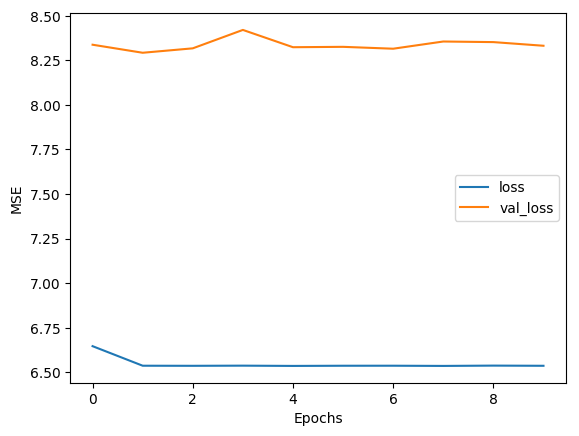

In [0]:
plt.plot(hist_lr.history['loss'])
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['loss'])

In [0]:
# Calculation of the the optimal sigma 
n = len(y_train)
y_hat_train = model_lr.predict(X_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_lr.predict(X_test) #Prediction on the testset

NLL_lr =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)
print('NLL on test:',NLL_lr)

Estimated variance  6.529544655089183
Estimated standart deviation  2.5552973711662568
NLL on training: 2.357174446397485
NLL on test: 2.4951030784474586


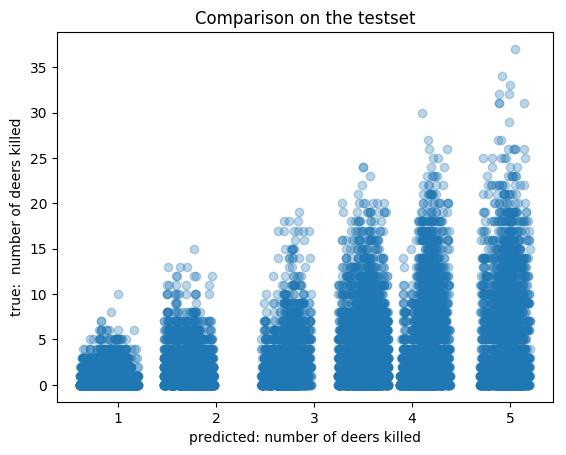

In [0]:
plt.scatter(model_lr.predict(X_test), y_test,alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted: number of deers killed')
plt.ylabel('true:  number of deers killed')
plt.show()

## 2.1 Poisson Regression


In [0]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, activation=tf.exp)(inputs) 
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 
model_p = Model(inputs=inputs, outputs=p_y) 

def NLL(y_true, y_hat): 
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 6s 42us/sample - loss: 1.9338 - val_loss: 2.0736
Epoch 2/10
140256/140256 [==============================] - 6s 41us/sample - loss: 1.9182 - val_loss: 2.0951
Epoch 3/10
140256/140256 [==============================] - 6s 41us/sample - loss: 1.9184 - val_loss: 2.0691
Epoch 4/10
140256/140256 [==============================] - 6s 41us/sample - loss: 1.9185 - val_loss: 2.0722
Epoch 5/10
140256/140256 [==============================] - 6s 41us/sample - loss: 1.9185 - val_loss: 2.0851
Epoch 6/10
140256/140256 [==============================] - 6s 41us/sample - loss: 1.9181 - val_loss: 2.1105
Epoch 7/10
140256/140256 [==============================] - 6s 41us/sample - loss: 1.9182 - val_loss: 2.0993
Epoch 8/10
140256/140256 [==============================] - 6s 40us/sample - loss: 1.9182 - val_loss: 2.1044
Epoch 9/10
140256/140256 [==============================] - 6s 41us/sample - 

Text(0.5, 0, 'Epochs')

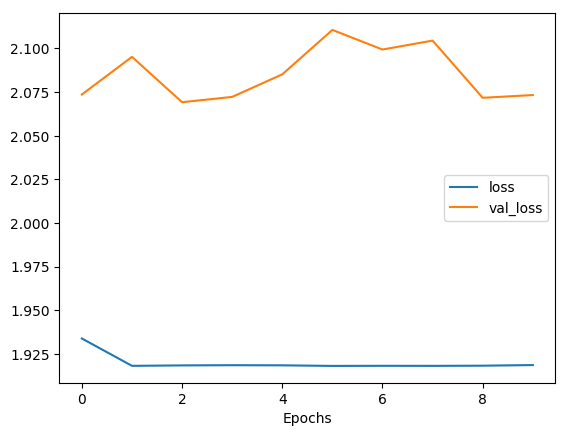

In [0]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [0]:
model = Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_p.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_p.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.9162271560367155
NLL on test: 2.0732461256523655


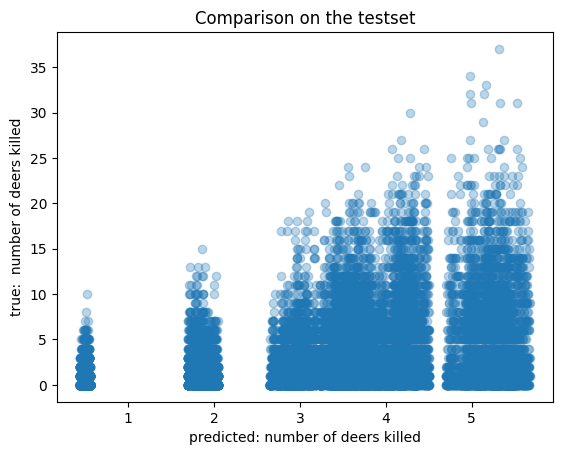

In [0]:
plt.scatter(y_hat_test, y_test,alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted: number of deers killed')
plt.ylabel('true:  number of deers killed')
plt.show()

## 2.2 Poisson Regression with hidden layers

In [0]:
inputs = Input(shape=(X_train.shape[1],))  
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
rate = Dense(1, activation=tf.exp)(x) 
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 
model_p = Model(inputs=inputs, outputs=p_y) 

def NLL(y_true, y_hat): 
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
_________________________________________________________________
distribution_lambda_3 (Distr ((None, 1), (None, 1))    0         
Total params: 12,821
Trainable params: 12,821
Non-trainable params: 0
_______________________________________________________

In [0]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 9s 66us/sample - loss: 1.9085 - val_loss: 2.0717
Epoch 2/10
140256/140256 [==============================] - 9s 65us/sample - loss: 1.8945 - val_loss: 2.0397
Epoch 3/10
140256/140256 [==============================] - 9s 65us/sample - loss: 1.8932 - val_loss: 2.0682
Epoch 4/10
140256/140256 [==============================] - 9s 65us/sample - loss: 1.8948 - val_loss: 2.0737
Epoch 5/10
140256/140256 [==============================] - 9s 65us/sample - loss: 1.8920 - val_loss: 2.0510
Epoch 6/10
140256/140256 [==============================] - 9s 64us/sample - loss: 1.8926 - val_loss: 2.0498
Epoch 7/10
140256/140256 [==============================] - 9s 64us/sample - loss: 1.8921 - val_loss: 2.0426
Epoch 8/10
140256/140256 [==============================] - 9s 64us/sample - loss: 1.8905 - val_loss: 2.0458
Epoch 9/10
140256/140256 [==============================] - 9s 64us/sample - 

Text(0.5, 0, 'Epochs')

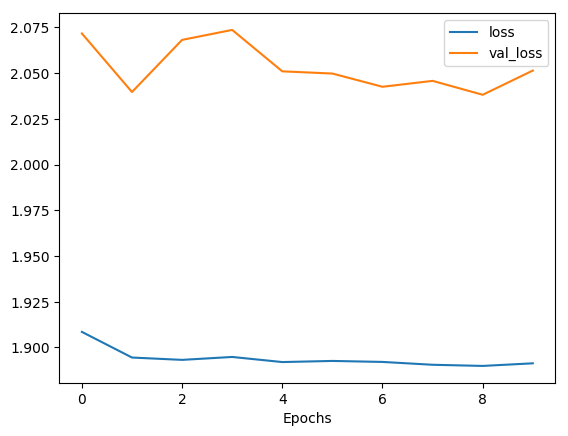

In [0]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [0]:
model = Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_p.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_p.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.8888157263020797
NLL on test: 2.051443500932493


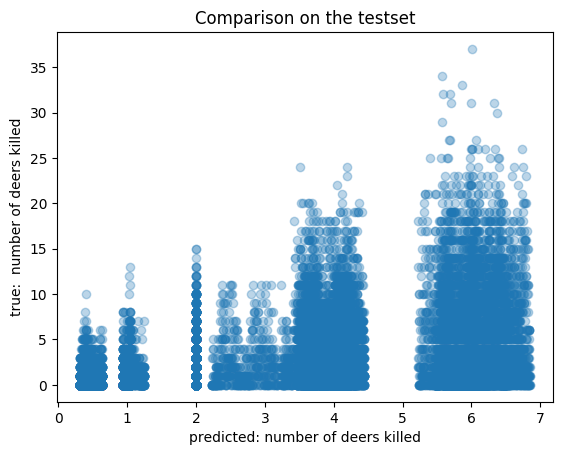

In [0]:
plt.scatter(y_hat_test, y_test,alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted: number of deers killed')
plt.ylabel('true:  number of deers killed')
plt.show()

## 3.1 Zero inflated Poisson Regression

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

### Definition of the distribution

In [0]:
# Listing 5.l_zi
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0. We use the squeeze function to flatten the tensor.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [0]:

## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs)#A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

#A A dense layer is used without activation. The transformation is done inside zero_inf function

model_zi.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 34        
_________________________________________________________________
distribution_lambda_5 (Distr ((None,), (None,))        0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 7s 53us/sample - loss: 1.8033 - val_loss: 1.9586
Epoch 2/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.7967 - val_loss: 1.9376
Epoch 3/10
140256/140256 [==============================] - 7s 50us/sample - loss: 1.7973 - val_loss: 1.9423
Epoch 4/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.7971 - val_loss: 1.9267
Epoch 5/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.7973 - val_loss: 1.9617
Epoch 6/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.7971 - val_loss: 1.9365
Epoch 7/10
140256/140256 [==============================] - 7s 51us/sample - loss: 1.7973 - val_loss: 1.9429
Epoch 8/10
140256/140256 [==============================] - 7s 52us/sample - loss: 1.7975 - val_loss: 1.9558
Epoch 9/10
140256/140256 [==============================] - 7s 51us/sample - 

Text(0.5, 0, 'Epochs')

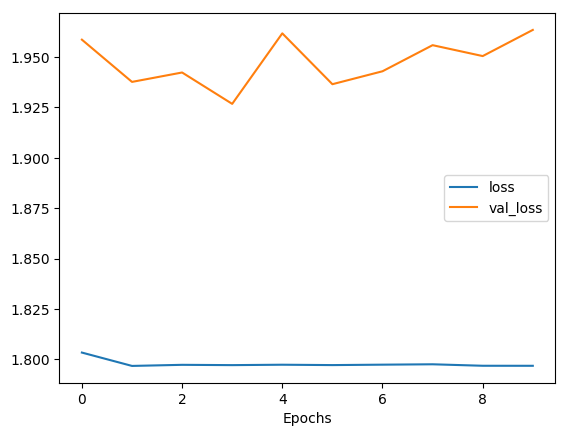

In [0]:
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [0]:
model = Model(inputs=inputs, outputs=p_y_zi.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_zi.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_zi.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.7988772925083805
NLL on test: 1.9633941257381005


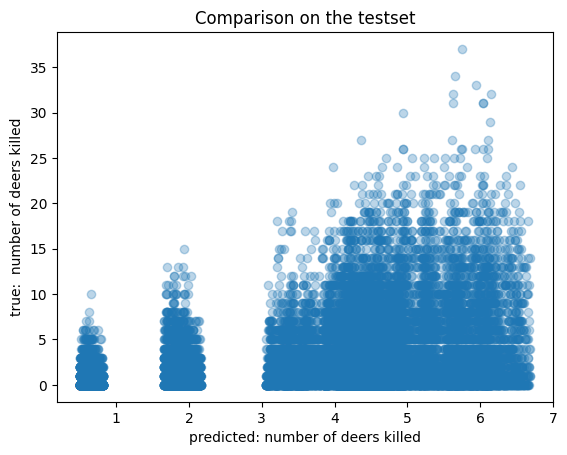

In [0]:
plt.scatter(y_hat_test, y_test,alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted: number of deers killed')
plt.ylabel('true:  number of deers killed')
plt.show()

## 3.2 Zero inflated Poisson Regression with hidden layers

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

### Definition of the distribution

In [0]:
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0. We use the squeeze function to flatten the tensor.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [0]:

## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
out = Dense(2)(x)#A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

#A A dense layer is used without activation. The transformation is done inside zero_inf function

model_zi.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 22        
_________________________________________________________________
distribution_lambda_6 (Distr ((None,), (None,))        0         
Total params: 12,832
Trainable params: 12,832
Non-trainable params: 0
______________________________________________________

In [0]:
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 11s 77us/sample - loss: 1.8019 - val_loss: 1.9232
Epoch 2/10
140256/140256 [==============================] - 11s 75us/sample - loss: 1.7852 - val_loss: 1.9122
Epoch 3/10
140256/140256 [==============================] - 11s 75us/sample - loss: 1.7831 - val_loss: 1.9095
Epoch 4/10
140256/140256 [==============================] - 11s 75us/sample - loss: 1.7810 - val_loss: 1.9242
Epoch 5/10
140256/140256 [==============================] - 11s 76us/sample - loss: 1.7803 - val_loss: 1.9098
Epoch 6/10
140256/140256 [==============================] - 11s 76us/sample - loss: 1.7822 - val_loss: 1.9268
Epoch 7/10
140256/140256 [==============================] - 11s 76us/sample - loss: 1.7826 - val_loss: 1.9304
Epoch 8/10
140256/140256 [==============================] - 11s 75us/sample - loss: 1.7819 - val_loss: 1.9184
Epoch 9/10
140256/140256 [==============================] - 11s 76us/

Text(0.5, 0, 'Epochs')

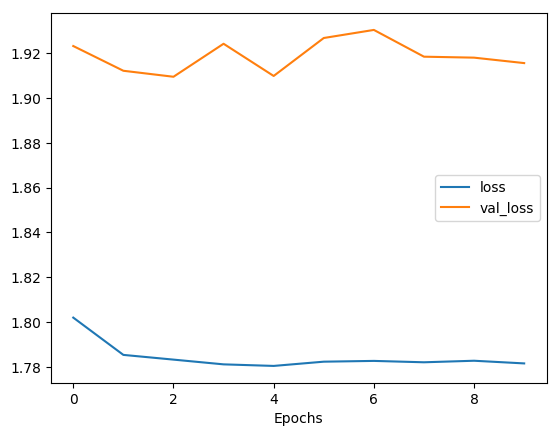

In [0]:
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [0]:
model = Model(inputs=inputs, outputs=p_y_zi.mean()) 
y_hat_test = model.predict(X_test).flatten()


NLL_train = model_zi.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_zi.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.7807756712821257
NLL on test: 1.915579262498307


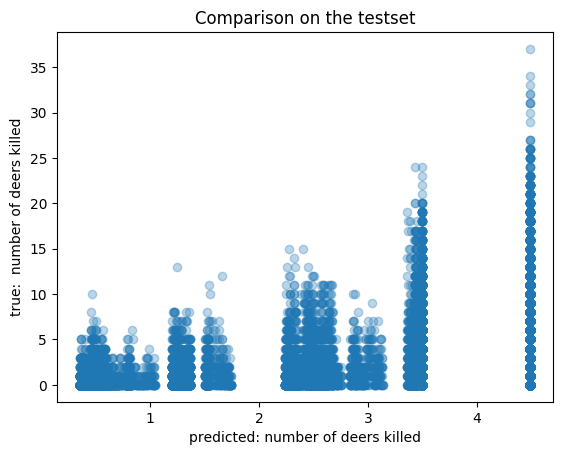

In [0]:
plt.scatter(y_hat_test, y_test,alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted: number of deers killed')
plt.ylabel('true:  number of deers killed')
plt.show()

## 4 Mixture Models

In [0]:
def quant_mixture_logistic(out, bits=8, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    high=2**bits - 1.)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [0]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(9)(inputs)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)

model = Model(inputs=inputs, outputs=p_y)

def NLL(y_true, y_hat):
  return -y_hat.log_prob(tf.reshape(y_true,(-1,)))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

model.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
dense_29 (Dense)             (None, 9)                 153       
_________________________________________________________________
distribution_lambda_17 (Dist ((None,), (None,))        0         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist_mm = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 8s 57us/sample - loss: 1.6300 - val_loss: 1.7037
Epoch 2/10
140256/140256 [==============================] - 8s 58us/sample - loss: 1.6163 - val_loss: 1.7027
Epoch 3/10
140256/140256 [==============================] - 8s 55us/sample - loss: 1.6160 - val_loss: 1.7064
Epoch 4/10
140256/140256 [==============================] - 8s 54us/sample - loss: 1.6156 - val_loss: 1.7104
Epoch 5/10
140256/140256 [==============================] - 7s 53us/sample - loss: 1.6158 - val_loss: 1.7060
Epoch 6/10
140256/140256 [==============================] - 8s 54us/sample - loss: 1.6156 - val_loss: 1.7058
Epoch 7/10
140256/140256 [==============================] - 7s 53us/sample - loss: 1.6157 - val_loss: 1.7095
Epoch 8/10
140256/140256 [==============================] - 7s 53us/sample - loss: 1.6155 - val_loss: 1.7158
Epoch 9/10
140256/140256 [==============================] - 8s 54us/sample - 

Text(0.5, 0, 'Epochs')

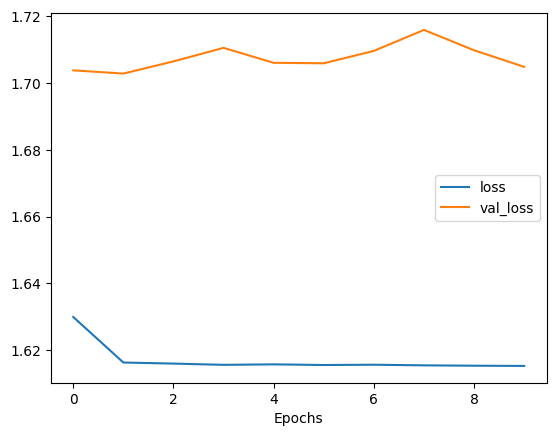

In [0]:
plt.plot(hist_mm.history['loss'])
plt.plot(hist_mm.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [0]:
print(-np.mean(model(X_train).log_prob(y_train)))
print(-np.mean(model(X_test).log_prob(y_test)))

1.6146194
1.7047585


In [0]:
NLL_train = model.evaluate(X_train, y_train,verbose=0) 
NLL_test = model.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

preds = np.zeros((1000,len(y_test.flatten())))
for i in tqdm(range(0,1000)):
  preds[i,:] = model(X_test).sample().numpy()
y_hat_test=np.average(preds,axis=0)


NLL on training: 1.6146192589144497
NLL on test: 1.7047584257169401


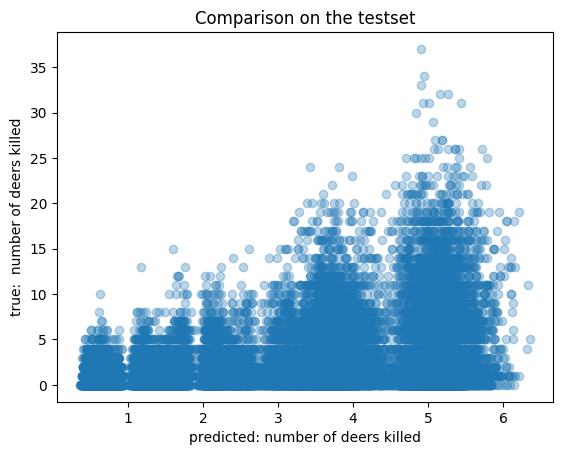

In [0]:
plt.scatter(y_hat_test, y_test,alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted: number of deers killed')
plt.ylabel('true:  number of deers killed')
plt.show()

## 4 Mixture Models with hidden layers

In [0]:
def quant_mixture_logistic(out, bits=8, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    high=2**bits - 1.)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [0]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
out = Dense(9)(x)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)

model = Model(inputs=inputs, outputs=p_y)

def NLL(y_true, y_hat):
  return -y_hat.log_prob(tf.reshape(y_true,(-1,)))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_32 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_33 (Dense)             (None, 9)                 99        
_________________________________________________________________
distribution_lambda_18 (Dist ((None,), (None,))        0         
Total params: 12,909
Trainable params: 12,909
Non-trainable params: 0
______________________________________________________

In [0]:
hist_mm = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Train on 140256 samples, validate on 35040 samples
Epoch 1/10
140256/140256 [==============================] - 11s 80us/sample - loss: 1.6247 - val_loss: 1.6984
Epoch 2/10
140256/140256 [==============================] - 11s 77us/sample - loss: 1.6169 - val_loss: 1.7001
Epoch 3/10
140256/140256 [==============================] - 11s 77us/sample - loss: 1.6159 - val_loss: 1.7025
Epoch 4/10
140256/140256 [==============================] - 11s 79us/sample - loss: 1.6158 - val_loss: 1.7031
Epoch 5/10
140256/140256 [==============================] - 11s 79us/sample - loss: 1.6157 - val_loss: 1.7154
Epoch 6/10
140256/140256 [==============================] - 11s 80us/sample - loss: 1.6173 - val_loss: 1.7083
Epoch 7/10
140256/140256 [==============================] - 11s 79us/sample - loss: 1.6172 - val_loss: 1.7053
Epoch 8/10
140256/140256 [==============================] - 11s 80us/sample - loss: 1.6169 - val_loss: 1.7070
Epoch 9/10
140256/140256 [==============================] - 11s 79us/

Text(0.5, 0, 'Epochs')

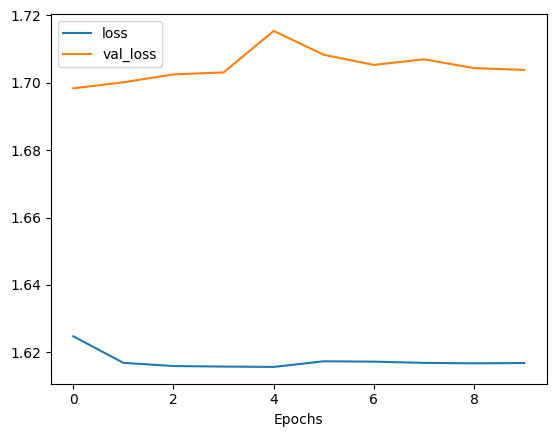

In [0]:
plt.plot(hist_mm.history['loss'])
plt.plot(hist_mm.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [0]:
print(-np.mean(model(X_train).log_prob(y_train)))
print(-np.mean(model(X_test).log_prob(y_test)))

1.6156197
1.703849


In [0]:
NLL_train = model.evaluate(X_train, y_train,verbose=0) 
NLL_test = model.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

preds = np.zeros((1000,len(y_test.flatten())))
for i in tqdm(range(0,1000)):
  preds[i,:] = model(X_test).sample().numpy()
y_hat_test=np.average(preds,axis=0)


NLL on training: 1.6156195610754842
NLL on test: 1.70384881175272


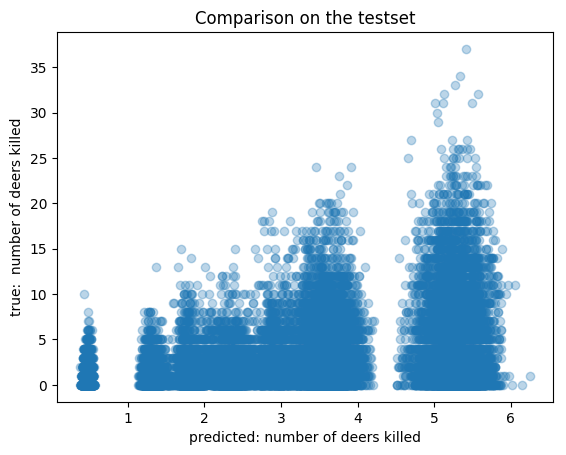

In [0]:
plt.scatter(y_hat_test, y_test,alpha=0.3)
plt.title('Comparison on the testset')
plt.xlabel('predicted: number of deers killed')
plt.ylabel('true:  number of deers killed')
plt.show()